Exercicis:
1. Descarrega el dataset adjunt, de registres de publicacions a Facebook sobre Tailàndia, i classifica els diferents registres utilitzant l'algorisme de K-means.
2. Classifica els diferents registres utilitzant l'algorisme de clustering jeràrquic.
3. Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette.

### Preparació del dataset

In [5]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, OrdinalEncoder

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")


In [6]:
df = pd.read_csv('/Users/juliacorominasfont/Desktop/DATA ANALYST/Bootcamp IT Academy/Tasques Sprints/Sprint_8_ML_unsupervised/Publicacions Facebook Thailandia.csv')
df.head(5)

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


In [7]:
df.shape

(7050, 16)

El dataset té 7050 registres i 16 columnes:
* status_id: número d'identificació de la publicació
* status_type: tipus de publicació
* status_published: data i hora de publicació
* num_reactions: número de reaccions
* num_comments: número de comentaris
* num_shares: número de vegades que s'ha compartit
* num_likes: número de likes que ha rebut la publicació
* num_loves: número de loves que ha rebut la publicació
* num_wows: número de wows que ha rebut la publicació
* num_hahas: número de hahas que ha rebut la publicació
* num_sads: número de sads que ha rebut la publicació
* num_angrys: número de angrys que ha rebut la publicació
* Column1
* Column2
* Column3
* Column4

In [8]:
df.duplicated().sum()

51

In [9]:
df.drop_duplicates(inplace=True) #eliminem els duplicats

In [10]:
df.shape

(6999, 16)

In [11]:
df.isnull().sum()

status_id              0
status_type            0
status_published       0
num_reactions          0
num_comments           0
num_shares             0
num_likes              0
num_loves              0
num_wows               0
num_hahas              0
num_sads               0
num_angrys             0
Column1             6999
Column2             6999
Column3             6999
Column4             6999
dtype: int64

In [12]:
#Eliminem les columnes que no farem servir per entrenar el model
df.drop(['status_id', 'status_published', 'Column1', 'Column2', 'Column3', 'Column4'], axis=1, inplace=True) 
df.head(5)

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,video,529,512,262,432,92,3,1,1,0
1,photo,150,0,0,150,0,0,0,0,0
2,video,227,236,57,204,21,1,1,0,0
3,photo,111,0,0,111,0,0,0,0,0
4,photo,213,0,0,204,9,0,0,0,0


La variable 'status_id' no ens aporta informació rellevant, i la variable 'status_published', tot i que podria ser útil per l'anàlisi, no ens és útil per entrenar el model. Les columnes 'Column1', 'Column2', 'Column3', 'Column4' tenen tots els seus registres buits.

### EDA

<Figure size 800x500 with 0 Axes>

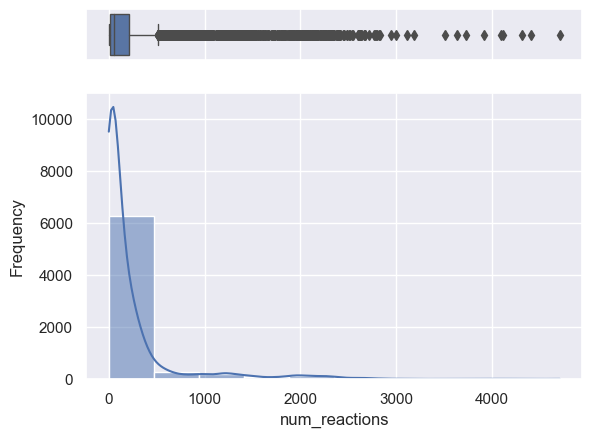

<Figure size 800x500 with 0 Axes>

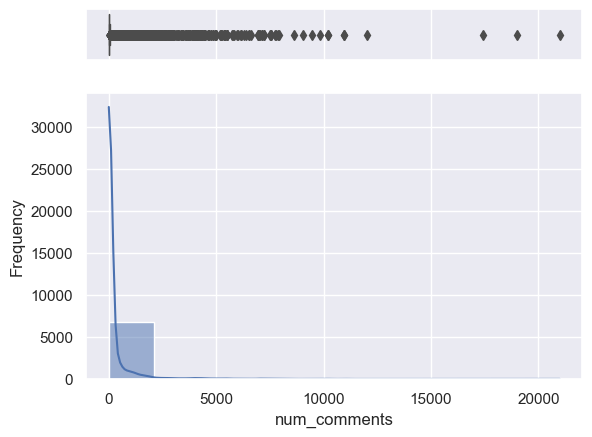

<Figure size 800x500 with 0 Axes>

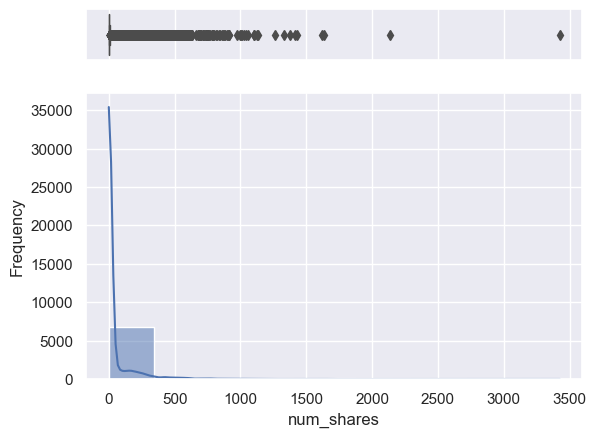

<Figure size 800x500 with 0 Axes>

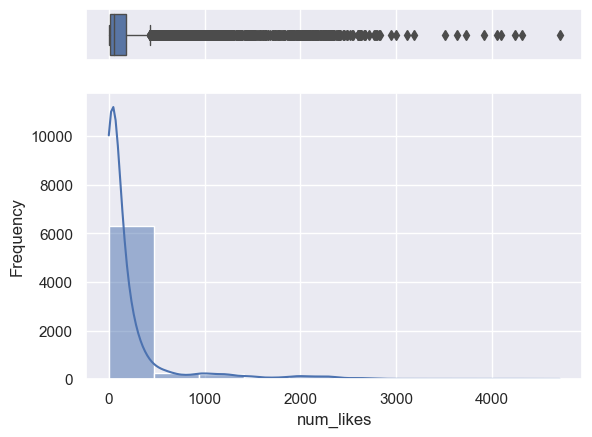

<Figure size 800x500 with 0 Axes>

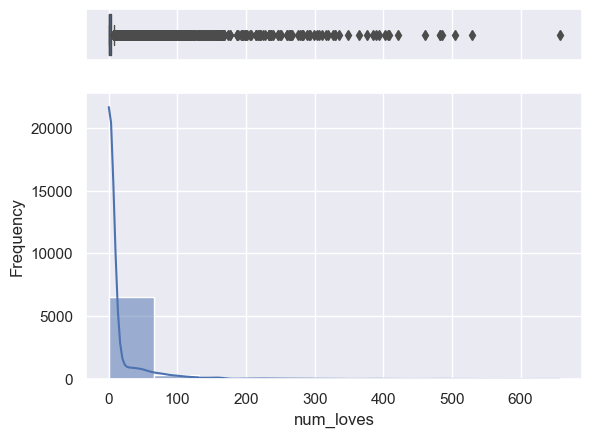

<Figure size 800x500 with 0 Axes>

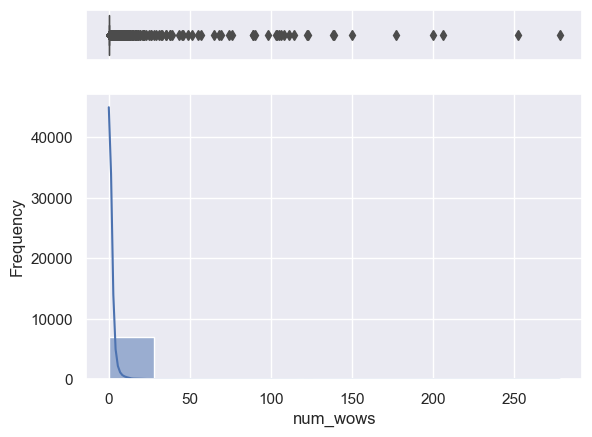

<Figure size 800x500 with 0 Axes>

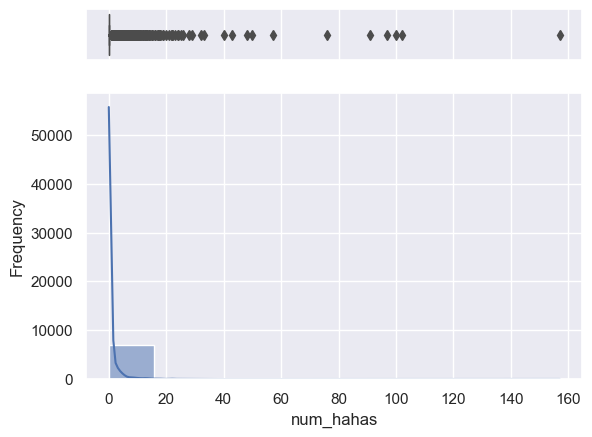

<Figure size 800x500 with 0 Axes>

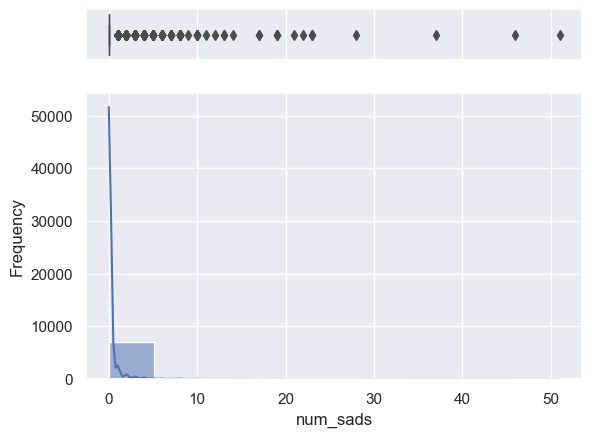

<Figure size 800x500 with 0 Axes>

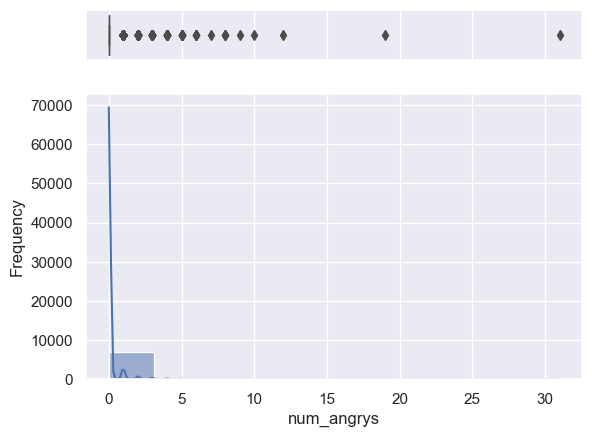

In [13]:
numeric_cols = ['num_reactions', 'num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']

for i in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.set()
    
    # Filtrem els valors no nuls en la columna actual
    filtered_data = df[df[i].notna()]
    
    # Creem un subplot amb dos àreas: boxplot i histogram
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    # Dibuixem el boxplot en la part superior i en forma horitzontal
    sns.boxplot(x=filtered_data[i], orient="h", ax=ax_box, linewidth=1.0)
    
    # Dibuixem l'histograma en la part inferiors
    sns.histplot(filtered_data[i], ax=ax_hist, bins=10, kde=True)
    
    # Afegim títols als subplots
    ax_box.set(xlabel='')
    ax_hist.set(xlabel=i)
    
    plt.gca().set(xlabel= i,ylabel='Frequency')

Veiem que cap de les variables segueix una distribució normal i que totes tenen molts outliers.

In [14]:
px.histogram(df, x='status_type', title='Histograma de tipus de publicació')

(Arxiu png dins la carpeta del repositori amb el nom 'status_type_countplot')

Veiem que el tipus de publicació més freqüent és la foto, seguida del vídeo. El link és la publicació menys utilitzada.

### Transformacions

#### Variables numèriques
Hem vist que no tenen una distribució normal i totes tenen outliers. Per tant, els hi apliquem el mateix procés de transformació (RobustScaler()).

In [15]:
numeric_features = numeric_cols
numeric_transformer = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy = 'median')),
        ('robust', RobustScaler())
    ]
)

#### Variables categòriques. 
OneHotEncoder per status_type.

In [16]:
categorical_features = ['status_type']
categorical_transformer = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy = 'most_frequent')),
        ('onehot', OneHotEncoder(sparse=False))
    ]
)

### Pipeline

Una vegada hem creat els Pipelines, utilitzem el ColumnTransformer per a cada una de les variables escollides.

In [17]:
preprocessor = ColumnTransformer(
    [
        ('categoricals', categorical_transformer, categorical_features),
        ('numericals', numeric_transformer, numeric_features), 
    ],
    remainder = 'drop'
)

In [18]:
preprocessor

ColumnTransformer(transformers=[('categoricals',
                                 Pipeline(steps=[('imputer_cat',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(sparse=False))]),
                                 ['status_type']),
                                ('numericals',
                                 Pipeline(steps=[('imputer_num',
                                                  SimpleImputer(strategy='median')),
                                                 ('robust', RobustScaler())]),
                                 ['num_reactions', 'num_comments', 'num_shares',
                                  'num_likes', 'num_loves', 'num_wows',
                                  'num_hahas', 'num_sads', 'num_angrys'])])

In [19]:
df_transf = preprocessor.fit_transform(df)
column_names = preprocessor.named_transformers_['categoricals']['onehot'].get_feature_names_out(['status_type']).tolist() + numeric_features
df_transf = pd.DataFrame(df_transf, columns=column_names)
df_transf

,status_type_link,status_type_photo,status_type_status,status_type_video,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,0.0,0.0,0.0,1.0,2.366834,23.090909,65.50,2.272727,30.666667,3.0,1.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.462312,-0.181818,0.00,0.563636,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.849246,10.545455,14.25,0.890909,7.000000,1.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.266332,-0.181818,0.00,0.327273,0.000000,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.778894,-0.181818,0.00,0.890909,3.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6994,0.0,1.0,0.0,0.0,0.155779,-0.181818,0.00,0.193939,0.000000,0.0,0.0,0.0,0.0
6995,0.0,1.0,0.0,0.0,-0.211055,-0.181818,0.00,-0.260606,0.333333,0.0,1.0,0.0,0.0
6996,0.0,1.0,0.0,0.0,-0.281407,-0.181818,0.00,-0.339394,0.333333,0.0,0.0,0.0,0.0
6997,0.0,1.0,0.0,0.0,1.472362,0.363636,5.50,1.769697,0.666667,0.0,0.0,0.0,0.0


Tenint en compte que el df té molt poques columnes (13), no seria necessari aplicar una reducció de dimensionalitat (PCA). Tot i així, s'aplicarà amb una finalitat educativa.

Primer de tot, hem d'averiguar quin és el número de components òptim.

Text(0, 0.5, 'Variança explicada acumulada')

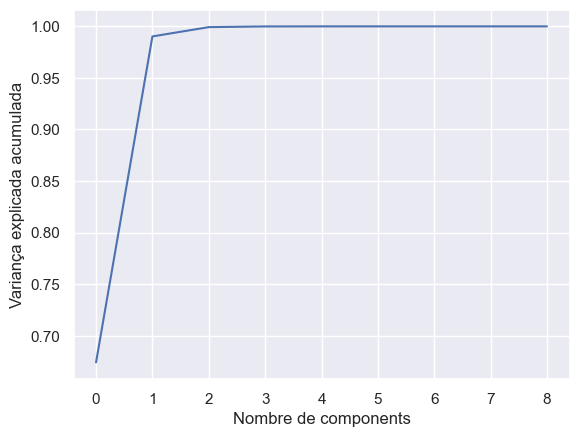

In [20]:
pca = PCA().fit(df[numeric_cols])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de components')
plt.ylabel('Variança explicada acumulada')

Segons el gràfic el nombre òptim de components és 3, doncs els components 0 a 2 expliquen el 100% de la variança. Apliquem doncs el PCA, amb 3 components, a les variables numèriques del df.

In [21]:
pca = PCA(n_components=3)
pca.fit(df[numeric_cols])
data_pca = df[numeric_cols].copy()
df_cat = df_transf.drop(numeric_cols, axis=1) #Separem les variables categòriques
data_pca = pca.transform(data_pca)

print("Estructura original:", df.shape)
print("Estructura transformada:", data_pca.shape)

Estructura original: (6999, 10)
Estructura transformada: (6999, 3)


In [22]:
df_pca = pd.DataFrame(data_pca)
df_pca

,0,1,2
0,370.724012,318.447289,199.895282
1,-242.101390,-54.108217,-18.154785
2,11.664909,-4.289780,18.031769
3,-251.857203,-108.359784,-16.299086
4,-227.121051,27.398363,-17.363345
...,...,...,...
6994,-257.360483,-138.963232,-15.252281
6995,-275.817349,-241.881440,-11.176395
6996,-279.210013,-260.667132,-10.691631
6997,-178.122893,222.256355,-7.376810


Aplicat el PCA a les variables numèriques, tornem a afegir les variables categòriques al df. 

In [23]:
df_prepared = pd.concat([df_pca, df_cat], axis=1)
df_prepared.head(5)

,0,1,2,status_type_link,status_type_photo,status_type_status,status_type_video
0,370.724012,318.447289,199.895282,0.0,0.0,0.0,1.0
1,-242.101390,-54.108217,-18.154785,0.0,1.0,0.0,0.0
2,11.664909,-4.289780,18.031769,0.0,0.0,0.0,1.0
3,-251.857203,-108.359784,-16.299086,0.0,1.0,0.0,0.0
4,-227.121051,27.398363,-17.363345,0.0,1.0,0.0,0.0


Ara ja tenim el df preparat per aplicar els models.

### Models

#### Exercici 1. Descarrega el dataset adjunt, de registres de publicacions a Facebook sobre Tailàndia, i classifica els diferents registres utilitzant l'algorisme de K-means.

In [24]:
X = df_prepared.values ## Extraiem els valors del df per introduir-los a l'algoritme

Primer de tot hem de definir el número de clusters, és a dir, el nombre d'agrupacions en els que volem que el model classifiqui els diferents registres. Agafarem el 3 com a número aleatori. En l'exercici 3 determinarem el nombre de clusters més òptim.

In [25]:
kmeans = KMeans(n_clusters= 3, init="random", random_state=42, n_init=10, max_iter=300)
kmeans.fit(X)

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

Calculem el SSE, les coordenades dels centroids (els centres dels clusters) i el número d'iteracions que du a terme l'algoritme fins trobar una solució. El SSE (Sum of Squared Errors) és el resultat de la suma al quadrat de les distàncies entre cada registre i el cluster més pròxim. Una menor inèrcia indica un millor clustering. 

In [26]:
print("El SSE més baix és:", kmeans.inertia_)
print("Les localitzacions dels centroids són:" , kmeans.cluster_centers_)
print("El número d'iteracions fins trobar la convergència és:", kmeans.n_iter_)

El SSE més baix és: 2685922779.545417
Les localitzacions dels centroids són: [[ 5.07653286e+03 -6.07414984e+02 -5.56117120e+01 -3.46944695e-18
   7.29927007e-03 -1.38777878e-17  9.92700730e-01]
 [-1.43389021e+02 -1.34018932e+02  1.75283892e-01  7.66703176e-03
   6.31200125e-01  4.36551400e-02  3.17477703e-01]
 [ 4.69032343e+02  1.99518227e+03  1.37973783e+01  2.97239915e-02
   4.43736730e-01  1.69851380e-01  3.56687898e-01]]
El número d'iteracions fins trobar la convergència és: 11


In [27]:
label = kmeans.predict(X)

Un cop fetes les prediccions, visualitzem els resultats.

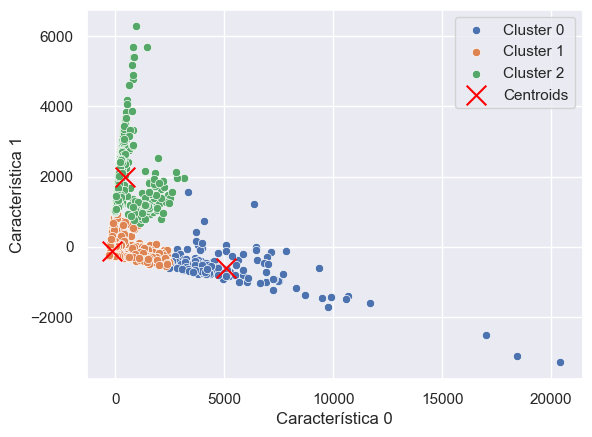

In [28]:
sns.scatterplot(x=X[label == 0, 0], y=X[label == 0, 1], label='Cluster 0')
sns.scatterplot(x=X[label == 1, 0], y=X[label == 1, 1], label='Cluster 1')
sns.scatterplot(x=X[label == 2, 0], y=X[label == 2, 1], label='Cluster 2')

##Marquem els centroides
centroids = []
for i in range(max(label) + 1):
    centroid = np.mean(X[label == i], axis=0)
    centroids.append(centroid)

centroids = np.array(centroids)

plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, c='red', label='Centroids')
plt.xlabel('Característica 0')
plt.ylabel('Característica 1')
plt.legend()
plt.show()

Veiem que alguns clusters estan més dispersos que els altres. A continuació fem un anàlisis de les característiques dels clusters:

In [43]:
cluster_stats = pd.DataFrame(index=range(max(label) + 1))

for i in range(max(label) + 1):
    cluster_points = X[label == i]
    cluster_stats.loc[i, 'Media_Característica_0'] = cluster_points[:, 0].mean()
    cluster_stats.loc[i, 'Media_Característica_1'] = cluster_points[:, 1].mean()
    cluster_stats.loc[i, 'Desviación_Característica_0'] = cluster_points[:, 0].std()
    cluster_stats.loc[i, 'Desviación_Característica_1'] = cluster_points[:, 1].std()

print("Estadístiques Descriptives por Cluster:")
print(cluster_stats)

Estadístiques Descriptives por Cluster:
   Media_Característica_0  Media_Característica_1  \
0             5076.532860             -607.414984   
1             -143.389021             -134.018932   
2              469.032343             1995.182268   

   Desviación_Característica_0  Desviación_Característica_1  
0                  2800.505963                   559.091185  
1                   334.459415                   187.573662  
2                   606.896749                   897.359714  


Tenint en compte les estadístiques descriptives de cada cluster, es podria fer les següent classificació:

- Cluster 0: "Altres característiques". 
Aquest cluster té punts més dispersos en totes dues característiques, amb desviacions estàndard relativament altes. Els valors en totes dues característiques tenen una variabilitat considerable.

- Cluster 1: "Característiques dominants",
ja que els punts que estan bastant prop del centroide i amb desviacions estàndard més baixes en comparació amb els altres clústers. Els valors tendeixen a estar centrats al voltant de la mitjana per a totes dues característiques, la qual cosa indica que són característiques dominants.

- Cluster 2: "Característiques específiques", 
doncs aquest cluster té punts més centralitzats en la Característica_0 i més dispersos en la Característica_1. La variabilitat en la Característica_0 és menor en comparació amb la Característica_1, indicant característiques més específiques.

#### Exercici 2. Classifica els diferents registres utilitzant l'algorisme de clustering jeràrquic.

Hi ha dos tipus de clustering jeràrquic: Agglomerative hierarchical clustering i Divisive Hierarchical clustering. A la pràctica el més comú és el primer.

En aquest tipus de clustering no hem de definir el nombre de clusters (k), sinó que el determinem a partir del dendograma.

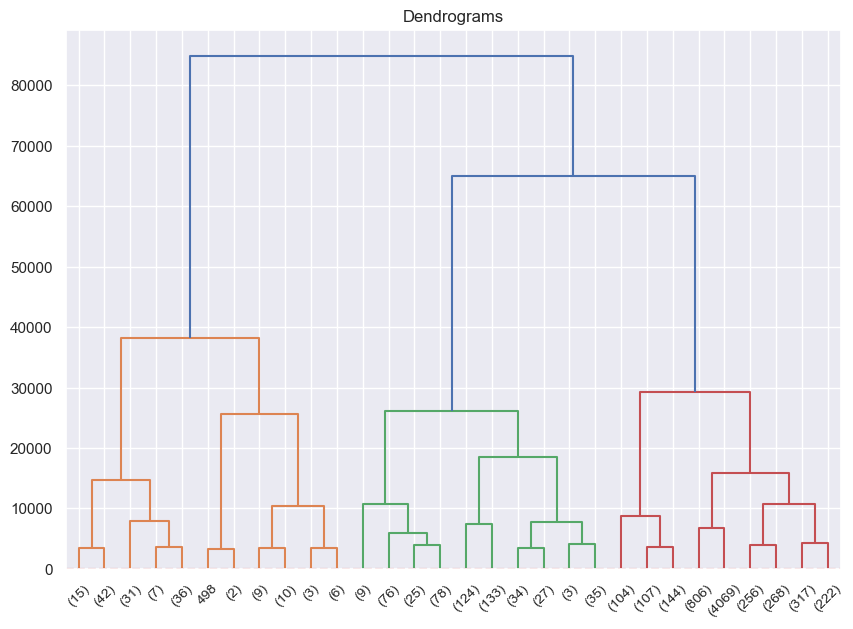

In [30]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df_prepared, method='ward'), truncate_mode = 'lastp')
plt.axhline(y=6, color='r', linestyle='--')

Per determinar el nombre de clusters hem de dividir la vertical més alta del dendograma per la meitat i comptar el nombre de verticals que intercepten amb aquesta horitzontal. En aquest cas, si ens fixem amb la vertical blava de l'esquerre, el resultat seria 3.

In [31]:
hier_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
c = hier_cluster.fit_predict(X)

Seguidament visualitzem els resultats:

<Figure size 1000x800 with 0 Axes>

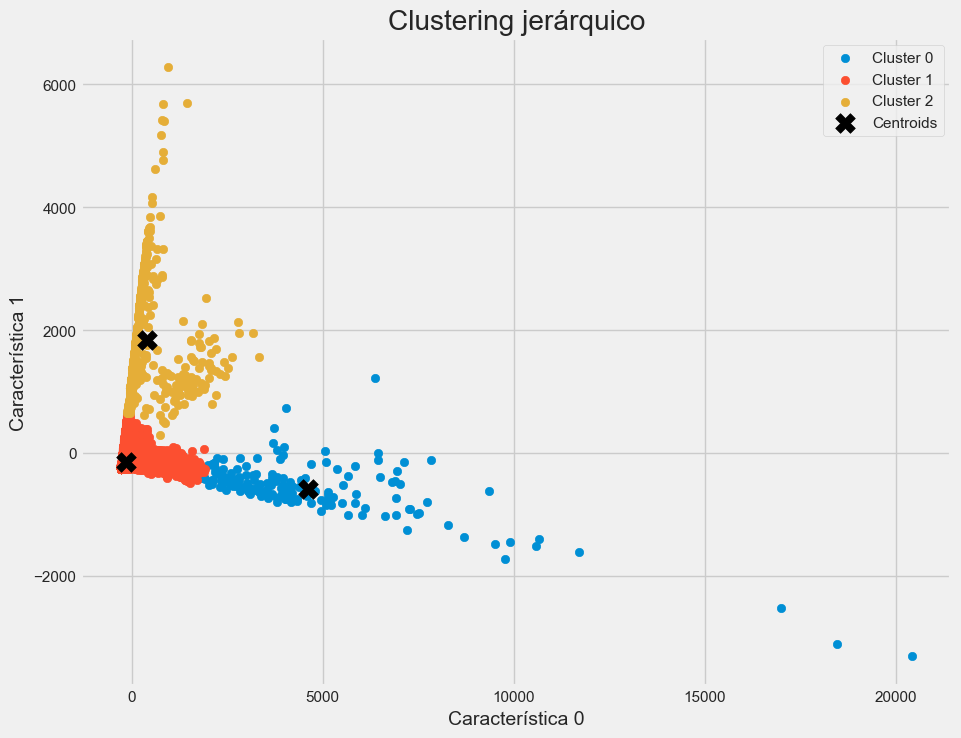

In [45]:
##Afegim els centroides
n_clusters=3

centroids = []
for cluster in range(n_clusters):
    cluster_points = X[c == cluster]
    centroid = np.mean(cluster_points, axis=0)
    centroids.append(centroid)

centroids = np.array(centroids)

plt.figure(figsize=(10, 8))
plt.figure(figsize=(10, 8))
for cluster in range(n_clusters):
    cluster_points = X[c == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', cmap='rainbow')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label='Centroids') #per graficar els centroides 
plt.title('Clustering jerárquico')
plt.xlabel('Característica 0')
plt.ylabel('Característica 1')
plt.legend() 
plt.show()

La distribució dels clusters és molt semblant a la distribució de l'exercici 1. Les posicions dels centroides també són molt semblants. A continuació fem un anàlisi descriptiu dels clusters:

In [44]:
df_clustered = pd.DataFrame({'Característica 0': X[:, 0], 'Característica 1': X[:, 1], 'Cluster': c})

n_clusters = 3

cluster_stats = pd.DataFrame(index=range(n_clusters))

for i in range(n_clusters):
    cluster_points = df_clustered[df_clustered['Cluster'] == i][['Característica 0', 'Característica 1']]
    cluster_stats.loc[i, 'Media_Característica_0'] = cluster_points['Característica 0'].mean()
    cluster_stats.loc[i, 'Media_Característica_1'] = cluster_points['Característica 1'].mean()
    cluster_stats.loc[i, 'Desviación_Característica_0'] = cluster_points['Característica 0'].std()
    cluster_stats.loc[i, 'Desviación_Característica_1'] = cluster_points['Característica 1'].std()

print("Estadístiques descriptives per Cluster:")
print(cluster_stats)

Estadístiques descriptives per Cluster:
   Media_Característica_0  Media_Característica_1  \
0             4626.997028             -579.372245   
1             -155.141589             -143.437573   
2              416.787687             1831.821597   

   Desviación_Característica_0  Desviación_Característica_1  
0                  2790.074350                   499.513648  
1                   299.107810                   161.047056  
2                   603.965678                   934.881139  


En aquest cas, es podria fer les següent classificació:

- Cluster 0: "Altres característiques"
Aquest cluster mostra una dispersió més gran en totes dues característiques, amb desviacions estàndard significatives. Les observacions en aquest cluster tenen valors que varien considerablement en totes dues característiques.

- Cluster 1: "Característiques dominants"
Aquest cluster està format per punts que es troben prop del centroid i amb desviacions estàndard més baixes en comparació amb altres clústers. Les observacions en aquest cluster tendeixen a estar centrades al voltant de la mitjana per a totes dues característiques, indicant característiques dominants i menor variabilitat.

- Cluster 2: "Característiques específiques"
Aquest cluster exhibeix punts més centralitzats en la Característica_0 i més dispersos en la Característica_1. La variabilitat en la Característica_0 és menor en comparació amb la Característica_1, suggerint característiques més específiques o especialitzades en la Característica_0 i una major variabilitat en la Característica_1.

Per tant, veiem que tots dos mètodes identifiquen clusters amb diferents nivells de variabilitat en les característiques, i que en ambdós hi ha un cluster que es pot interpretar com a "Característiques dominants" amb valors centrats al voltant de la mitjana.

D'altra banda, en els gràfics es poden apreciar petites diferències en la definició dels clusters i en com es distribueixen les observacions en relació amb els centroides.

#### Exercici 3. Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette.

El silhouette coefficient és un mètode per escollir el nombre apropiat de clusters. També ho és el elbow method, que es pot utilitzar com a una tècnica complementària.

Ens centrarem en el primer. El silhouette coefficient mesura la cohesió i separació dels clusters, quantificant com de bé encaixa un punt en el cluster que se li ha assignat. Per fer-ho té en compte dos factors: 
1. la proximitat del punt als altres punts del clusters i;
2. la distància entre el punt i els altres punts del cluster. 

Els valors d'aquests coeficient oscil·len entre -1 i 1. Els valors més alts indiquen que les mostres estan més aprop del cluster assignat que dels altres clusters.

Començant per KMeans:

In [34]:
silhouette_coefficients = []

n_clusters=[2,3,4,5,6,7]
for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)

silhouette_coefficients

[0.8739423617826101,
 0.8131581311514451,
 0.8187423085138257,
 0.7873961306058976,
 0.7619995562419083,
 0.7635775303613984]

Veiem que el nombre més òptim de clusters és 2, ja que és el que ha obtingut el silhouette score més alt (0,87)

Visualitzem els resultats:

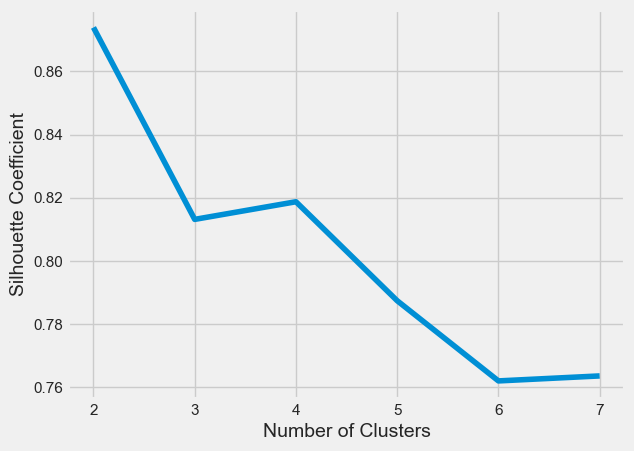

In [35]:
plt.style.use("fivethirtyeight")
plt.plot(n_clusters, silhouette_coefficients)
plt.xticks(n_clusters)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

En el cas del clustering jeràrquic:

In [36]:
silhouette_coefficients = []

n_clusters=[2,3,4,5,6,7]
for n in n_clusters:
    cluster = AgglomerativeClustering(n_clusters=n)
    cluster.fit(X)
    score = silhouette_score(X, cluster.labels_)
    silhouette_coefficients.append(score)

silhouette_coefficients

[0.8650589215109058,
 0.8032019773432351,
 0.8046435543467967,
 0.7455086044679202,
 0.7531946031263603,
 0.7536080842680555]

En aquest cas el nombre més òptim de cluster també és 2, amb una puntuació de 0.86.

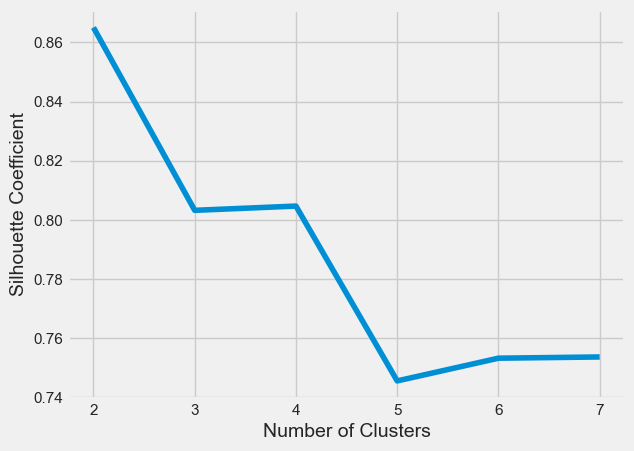

In [37]:
plt.style.use("fivethirtyeight")
plt.plot(n_clusters, silhouette_coefficients)
plt.xticks(n_clusters)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()